# Importing and Plotting 2019-nCoV Data

This notebook loads a snapshot of the coronavirus [dataset](https://systems.jhu.edu/research/public-health/ncov/) as compiled by the Johns Hopkins Center for Systems Science and Engineering.

The notebook shows some basic visualization techniques:
1. Load the coronavirus data into a Pandas DataFrame and plot
2. Load world, China, and US shapefiles into GeoDataFrames
3. Merge the coronavirus DataFrame with the GeoDataFrames
4. Display on a map

## Setup and Load nCoV Data

For this example we are using a snapshot of the data from 12pm Jan 25, 2019. 

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas
import numpy as np
from shapely.geometry import Point
import math

#Generate inline plots
%matplotlib inline

jan25_12pm = pd.read_csv('./data/snapshot_jan25_12pm.csv',parse_dates=['Last Update'])
jan25_12pm.head()

,Province/State,Country/Region,Last Update,Confirmed,Suspected,Recovered,Deaths
0,Hubei,Mainland China,2020-01-25 12:00:00,761,NaN,32.0,40
1,Guangdong,Mainland China,2020-01-25 12:00:00,78,NaN,2.0,NaN
2,Zhejiang,Mainland China,2020-01-25 12:00:00,62,NaN,1.0,NaN
3,Chongqing,Mainland China,2020-01-25 12:00:00,57,NaN,NaN,NaN
4,Hunan,Mainland China,2020-01-25 12:00:00,43,NaN,NaN,NaN


In [89]:
cases_by_country = jan25_12pm.groupby(['Country/Region'])['Confirmed'].sum().to_frame(name = 'Confirmed').reset_index()
cases_by_country.columns = ['country','confirmed']
cases_by_country.sort_values(by='confirmed', ascending=False, inplace=True)
cases_by_country.head()

,country,confirmed
5,Mainland China,1399
11,Thailand,7
2,Hong Kong,5
0,Australia,4
1,France,3


## Bar Chart Visualization
Plot the confirmed cases against location using a log scale.

Text(0.5, 1.0, 'Confirmed 2019-nCoV')

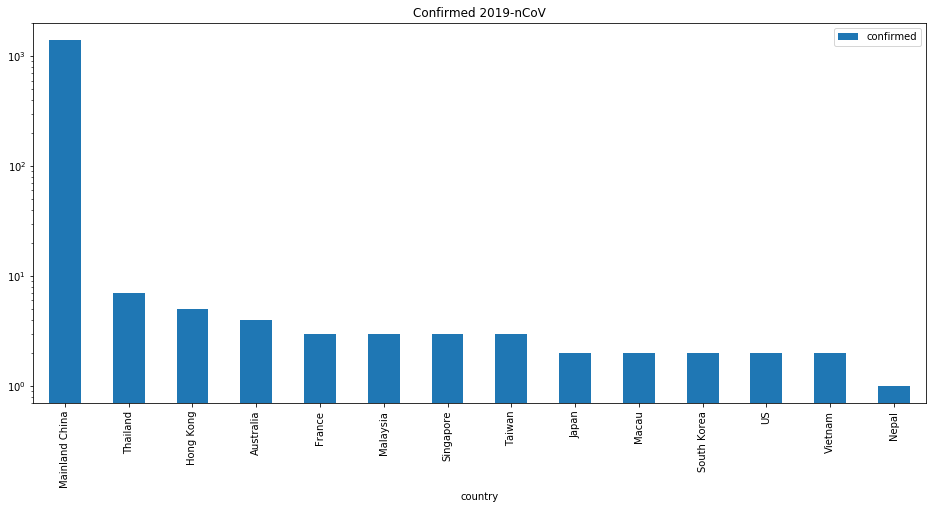

In [90]:
def location_label(row):
    if pd.isnull(row['Province/State']):
        return row['Country/Region']
    else:
        return row['Province/State']

ax = cases_by_country.plot.bar(x='country', y='confirmed', figsize=(16, 7))
ax.set_yscale('log')
ax.set_title('Confirmed 2019-nCoV')

## Geoplotting

Our end goal is to plot the outbreak data on a map. Since the resolution of the data varies, we need to break this up into parts. For China we have province-level resolution. For the US we have state-level resolution. For the remainder we have country-level resolution.

### World Data
First let's plot the data where we have country-level resolution on a world map. We will load a shapefile from We [Natural Earth](https://www.naturalearthdata.com/) as the basis using GeoPandas.

In [91]:
world_lines = geopandas.read_file('zip://./shapefiles/ne_50m_admin_0_countries.zip')

world = world_lines[(world_lines['POP_EST']>0) & (world_lines['ADMIN']!='Antarctica')]

world = world.rename(columns = {'ADMIN':'name'}) 

Merge the coronavirus data with the world geodata using the country name as the join key. Conveniently this will _not_ match the names `Mainland China` and `US` as they are labelled differently in the geodata. Then plot the combined dataset with the GeoPandas plot method.

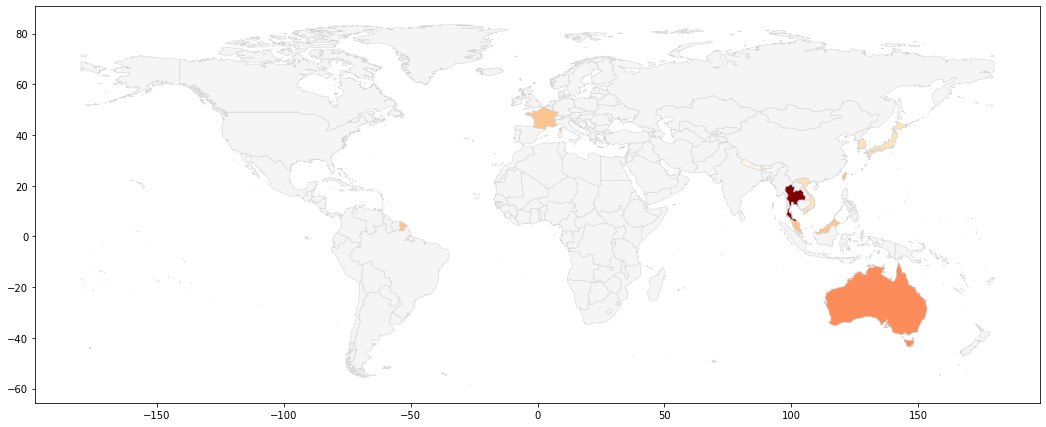

In [92]:
world_ncov = world.merge(jan25_12pm, left_on='name', right_on='Country/Region')

w_ax = world.plot(color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8));
world_ncov.plot(ax=w_ax, column='Confirmed', cmap='OrRd', edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8));

### China Data

Next we want to plot to province-level outbreak data from China. Do do so we need to find geographic data that has province and state boundaries. I use geo data from [GADM](https://gadm.org/index.html) which is available for non-commercial use under their [license](https://gadm.org/license.html).

The geopackage file has 4 layers

```py
layers: ['gadm36_CHN_0', 'gadm36_CHN_1', 'gadm36_CHN_2', 'gadm36_CHN_3']
```

I select `gadm36_CHN_1` as the province-level data and `gadm36_CHN_2` as the city-level data. Some of the province names in the outbreak data match provinces and the others match cities. Someone who knows China geography better than I do may understand why, but this method seems to work.

The `Hong Kong` term doesn't match a city or province in the geo data, so I just add it to the `Guangdong` province numbers. Again, there are geopolitical complications here that I cannot pretend to understand.

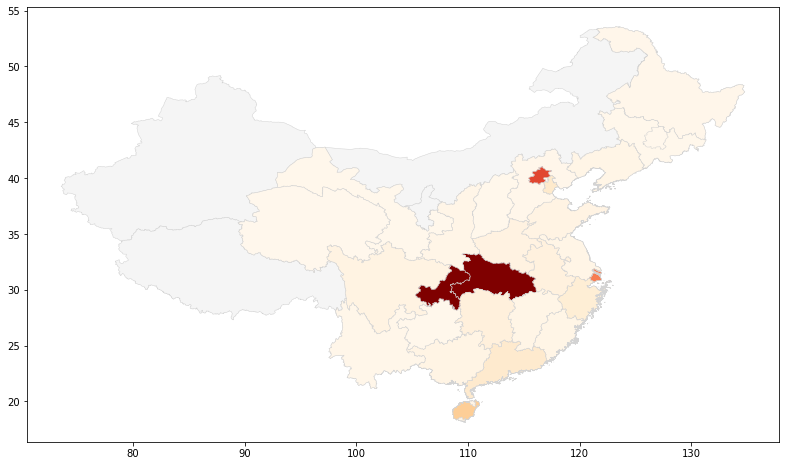

In [93]:
china = world_lines[world_lines['ADMIN']=='China']
# layers: ['gadm36_CHN_0', 'gadm36_CHN_1', 'gadm36_CHN_2', 'gadm36_CHN_3']
china_provinces = geopandas.read_file('./shapefiles/gadm36_CHN.gpkg', layer='gadm36_CHN_1')
china_provinces = china_provinces.rename(columns = {'NAME_1':'name'}) 

china_cities = geopandas.read_file('./shapefiles/gadm36_CHN.gpkg', layer='gadm36_CHN_2')
china_cities = china_cities.rename(columns = {'NAME_2':'name'}) 

# set to same projection
china_provinces.crs = china.crs
china_cities.crs = china.crs

# merge with coronavirus data
china_provinces_ncov = china_provinces.merge(jan25_12pm, left_on='name', right_on='Province/State')
china_cities_ncov = china_cities.merge(jan25_12pm, left_on='name', right_on='Province/State')

# include Hong Kong numbers in Guangdong
g_idx = china_provinces['name']=='Guangdong'
hk_confirmed = jan25_12pm.loc[jan25_12pm['Province/State']=='Hong Kong','Confirmed'].values[0]
china_provinces_ncov.loc[g_idx,'Confirmed'] += hk_confirmed

cn_ax = china_provinces.plot(color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8))
china_provinces_ncov.plot(ax=cn_ax, column='Confirmed', cmap='OrRd', edgecolor = "lightgrey", linewidth = 0.5);
china_cities_ncov.plot(ax=cn_ax, column='Confirmed', cmap='OrRd', edgecolor = "lightgrey", linewidth = 0.5);

### USA Data

Last we plot the US state boundaries using a shapefile from [Natural Earth](https://www.naturalearthdata.com/) and merge with the coronavirus data.

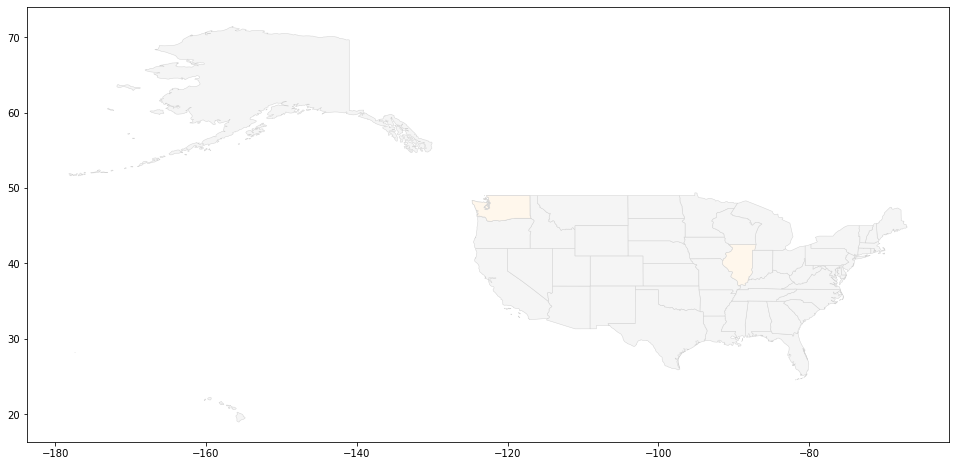

In [94]:
state_lines = geopandas.read_file('zip://./shapefiles/ne_50m_admin_1_states_provinces.zip')
us_state_lines = state_lines[state_lines['iso_a2']=='US']

# merge with coronavirus data
us_state_ncov = us_state_lines.merge(jan25_12pm, left_on='name', right_on='Province/State')

us_ax = us_state_lines.plot(color = "whitesmoke", edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8));
us_state_ncov.plot(ax=us_ax, column='Confirmed', cmap='OrRd', edgecolor = "lightgrey", linewidth = 0.5, figsize=(18, 8));

### Combined Geodata
The final step is to combine all the merged data into one large GeoDataFrame using `concat`.

In [95]:
cols = ['name','Confirmed','geometry']
ncov = pd.concat([world_ncov[cols],us_state_ncov[cols],china_provinces_ncov[cols],china_cities_ncov[cols]],ignore_index=True)

ncov['log_confirmed'] = ncov.apply(lambda x: math.log10(x['Confirmed']), axis=1)
ncov[['name','Confirmed','log_confirmed']].sort_values(by='log_confirmed', ascending=False).head()

,name,Confirmed,log_confirmed
24,Hubei,761,2.881385
17,Guangdong,83,1.919078
38,Zhejiang,62,1.792392
14,Chongqing,57,1.755875
40,Chongqing,57,1.755875


Finally, plot the combined data.

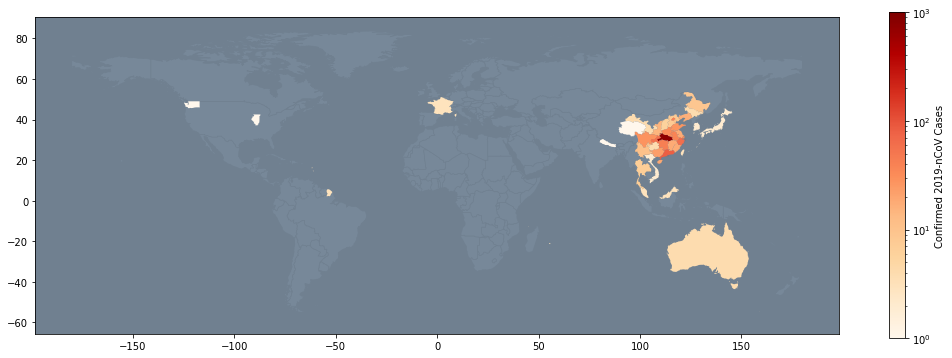

In [96]:
ax = world.plot(
    color = "lightslategray", 
    edgecolor = "slategray", 
    linewidth = 0.5, figsize=(18, 6));
ax.set_facecolor("slategray")
ax.set_clip_on(False)
#ax.axis('off')

ncov.plot(
    ax=ax, 
    column='Confirmed', 
    norm=colors.LogNorm(vmin=1, vmax=1000),
    legend=True,
    legend_kwds={'label': "Confirmed 2019-nCoV Cases"},
    cmap='OrRd')